# Get data

In [4]:
import gzip
import os
import shutil
import pandas as pd
from pyarrow.parquet import read_table
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.cluster import HDBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split

# You can also define custom functions, classes, and other code in this module.


In [ ]:
input_gz_file = 'GSE185948_count_RNA.rds.gz'
output_rds_file = 'data_for_r.rds'

# Open the compressed file and extract it
with gzip.open(input_gz_file, 'rb') as f_in, open(output_rds_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f'{input_gz_file} has been successfully uncompressed to {output_rds_file}.')

In [ ]:
import gzip
import shutil

input_gz_file = 'GSE185948_metadata_RNA.csv.gz'
output_csv_file = 'uncompressed_metadata.csv'

# Open the compressed file and extract it
with gzip.open(input_gz_file, 'rb') as f_in, open(output_csv_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f'{input_gz_file} has been successfully uncompressed to {output_csv_file}.')

In [3]:
output_path = '../output'
if not os.path.exists(output_path):
    os.makedirs(output_path)

NameError: name 'os' is not defined

In [ ]:
metadata = pd.read_csv('uncompressed_metadata.csv')

In [ ]:
metadata

R code below

## Data Preparation

In [ ]:
#pip install memory_profiler

In [ ]:
def load_data(data_path, row_info_path, column_info_path):
    # Load non_zero parquet data
    table = read_table(data_path)
    nonzero_data = table.to_pandas()
    
    # Adjust column indices to be 0-based
    nonzero_data['col_indices'] = nonzero_data['col_indices'] - 1
    
    # Load row and column index info
    rows = pd.read_csv(row_info_path)
    row_names = rows.iloc[:, 1].to_list()
    
    columns = pd.read_csv(column_info_path)
    column_names = columns.iloc[:, 1].to_list()
    
    # Convert the sparse matrix to a dense DataFrame
    sparse_matrix = coo_matrix(
        (nonzero_data['nonzero_elements'], (nonzero_data['row_indices'], nonzero_data['col_indices'])),
        shape=(len(row_names), len(column_names))
    )
    
    
   

    print('Returning sparse_matrix, column_names, and row_names')
    
    return sparse_matrix, column_names, row_names


class SparseTrainTestSplit(BaseEstimator, TransformerMixin):
    def __init__(self, test_size=0.2, random_state=None):
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y=None):
        # Not needed for this class
        return self

    def transform(self, X):
        # Split the data using train_test_split
        sparse_train, sparse_test, train_indices, test_indices = train_test_split(
            X, row_indices, test_size=self.test_size, random_state=self.random_state
        )

        # Convert the split data back to coo_matrix
        sparse_train = coo_matrix(sparse_train)
        sparse_test = coo_matrix(sparse_test)

        return sparse_train, sparse_test, train_indices, test_indices


In [ ]:
data_path = 'non_zero.parquet'
row_info_path = 'row_names.csv'
column_info_path = 'col_names.csv'
#sparse_matrix = coo_matrix((data['nonzero_elements'], (data['row_indices'], data['col_indices'])))
sparse_matrix, row_names, column_names = load_data(data_path, row_info_path, column_info_path)


In [ ]:
row_indices = np.arange(sparse_matrix.shape[0])

In [ ]:
split_pipeline = Pipeline([
    ('splitter', SparseTrainTestSplit(test_size=0.2, random_state=42)),
    # Add other steps in the pipeline as needed
])

# Fit and transform the pipeline
sparse_train, sparse_test, train_indices, test_indices = split_pipeline.fit_transform(sparse_matrix)


In [ ]:
import os
import numpy as np

class DataClean:
    def __init__(self, remove_by_column=True):
        self.remove_by_column = remove_by_column
        self.output_folder = "../output"
        
        # Create the output folder if it doesn't exist
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder)

    def fit(self, X, y=None):
        # Check if there are NaN values in the data
        self.has_nan_values = np.isnan(X.data).any()

        with open(os.path.join(self.output_folder, "na_info.txt"), "w") as f:
            if self.has_nan_values:
                # Find rows and columns with NaN values
                self.rows_with_nan = self.find_rows_with_nan(X)
                self.columns_with_nan = self.find_columns_with_nan(X)

                f.write("Rows with NaN Values:\n")
                f.write(", ".join(map(str, self.rows_with_nan)))
                f.write("\nTotal Rows with NaN Values: {}\n".format(len(self.rows_with_nan)))

                f.write("\nColumns with NaN Values:\n")
                f.write(", ".join(map(str, self.columns_with_nan)))
                f.write("\nTotal Columns with NaN Values: {}\n".format(len(self.columns_with_nan)))
            else:
                f.write("No NaN Values Found in the Data.\n")

        return self

    def transform(self, X):
        if self.has_nan_values:
            if self.remove_by_column:
                X = self._remove_nan_by_column(X)
            else:
                X = self._remove_nan_by_row(X)

        return X

    def _remove_nan_by_column(self, X):
        nan_mask = np.isnan(X.data)
        valid_columns = np.unique(X.col[~nan_mask])
        X = X.tocsc()[:, valid_columns].tocoo()
        return X

    def _remove_nan_by_row(self, X):
        if not isinstance(X, coo_matrix):
            raise ValueError("Input must be a sparse COO matrix.")
    
        non_nan_rows = ~np.isnan(X.sum(axis=1).A.ravel())
        X = X.tocsr()[non_nan_rows].tocoo()
        return X

    def find_rows_with_nan(self, X):
        nan_mask = np.isnan(X.data)
        rows_with_nan = np.unique(X.row[nan_mask])
        return rows_with_nan

    def find_columns_with_nan(self, X):
        nan_mask = np.isnan(X.data)
        columns_with_nan = np.unique(X.col[nan_mask])
        return columns_with_nan


In [ ]:
clean_and_pca_pipeline = Pipeline([
    ('cleaner', DataClean()),  # CleanData is performed first
    ('scaler', StandardScaler(with_mean=False)),
    ('pca', TruncatedSVD(n_components=2))
])

# Fit the pipeline to training
clean_and_pca_pipeline.fit(sparse_train)
# Transform the training data
pca_sparse_train = clean_and_pca_pipeline.transform(sparse_train)

pca_sparse_test = clean_and_pca_pipeline.transform(sparse_test)

In [ ]:
def reindex(df, indices, columns, names):
    row_names_indices = [names[i] for i in indices]
    df_with_indices = pd.DataFrame(df, columns=columns, index=row_names_indices)
    return df_with_indices

columns=["PC1", "PC2"]
train_pca_df_test = reindex(pca_sparse_train, indices =train_indices,  columns  = columns, names = row_names)
test_pca_df_test = reindex(pca_sparse_test, indices =test_indices,  columns  = columns, names = row_names)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(10, 6))

# Create a boxplot for both variables in train_pca_df
sns.boxplot(data=train_pca_df, orient="h", palette="Set2")
plt.title('Boxplot of Variables in train_pca_df')
plt.xlabel('Value')

# Show the plot
plt.show()

In [ ]:
max_pc1_row = train_pca_df[train_pca_df['PC1'] == train_pca_df['PC1'].max()]

max_pc1_index = max_pc1_row.index[0]  # Assuming there is only one row with the maximum PC1 value

# Find the associated row in metadata
associated_metadata = metadata[metadata['name'] == max_pc1_index]


In [ ]:
pc1_mean = train_pca_df['PC1'].mean()
pc1_std = train_pca_df['PC1'].std()

# Get the maximum PC1 value
max_pc1_value = train_pca_df['PC1'].max()

# Calculate the z-score
z_score = (max_pc1_value - pc1_mean) / pc1_std

print(f"The maximum PC1 value is {max_pc1_value:.2f}")
print(f"The z-score for the maximum PC1 value is {z_score:.2f}")

In [ ]:
max_pc1_row

In [ ]:
associated_metadata

In [ ]:
import pandas as pd

# Calculate the mean for numeric columns and the most common level for categorical columns
mean_values = metadata.apply(lambda col: col.mean() if pd.api.types.is_numeric_dtype(col) else col.mode().iloc[0])

# Create a DataFrame to show the mean values
mean_metadata = pd.DataFrame(mean_values, columns=['Mean Value'])

# Set the display format for float values
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
mean_metadata

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Find the maximum value of PC1
max_pc1 = train_pca_df['PC1'].max()

# Create a new DataFrame without the rows where PC1 is equal to the maximum value
train_pca_df_filtered = train_pca_df[train_pca_df['PC1'] != max_pc1]

# Set up the figure
plt.figure(figsize=(10, 6))

# Create a boxplot for both variables in train_pca_df_filtered
sns.boxplot(data=train_pca_df_filtered, orient="h", palette="Set2")
plt.title('Boxplot of Variables in train_pca_df (Excluding Max PC1)')
plt.xlabel('Value')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(8, 6))

# Create a scatter plot
sns.scatterplot(x='PC1', y='PC2', data=train_pca_df, marker='o', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Two-Dimensional Data Visualization')

# Show the plot
plt.grid(True)

In [ ]:
max_pc1_row = train_pca_df['PC1'].idxmax()

# Identify the row with the maximum value in PC2
max_pc2_row = train_pca_df['PC2'].idxmax()

# Create a dataset without the rows with maximum values in PC1 and PC2
train_without_outliers = train_pca_df.drop([max_pc1_row, max_pc2_row])

In [ ]:
plt.figure(figsize=(8, 6))

# Create a scatter plot using train_without_outliers
sns.scatterplot(x='PC1', y='PC2', data=train_without_outliers, marker='o', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Two-Dimensional Data Visualization without Outliers')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
train_without_outliers.to_csv('train_pca_df.csv')
test_pca_df.to_csv('test_pca_df.csv')


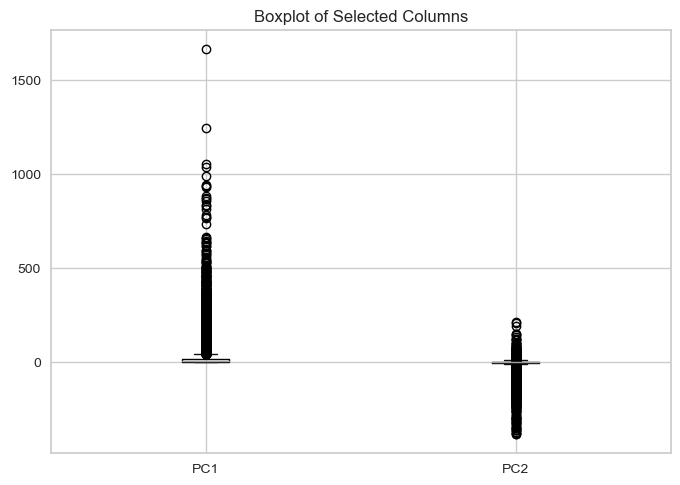

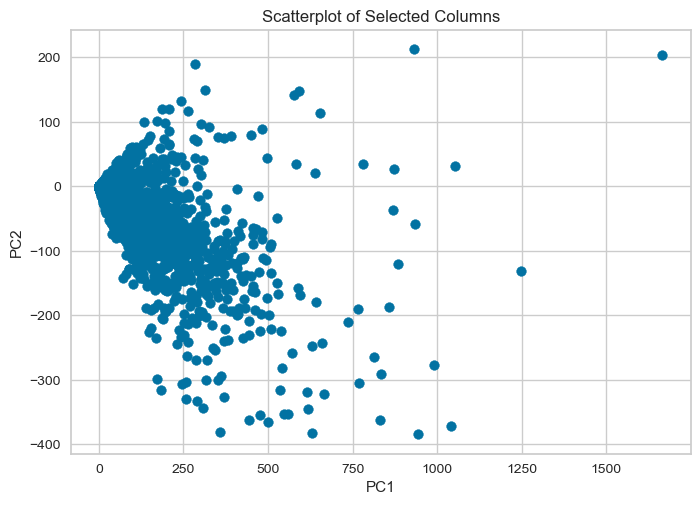

Z-scores:
[[0.34508727 0.28106016]
 [4.16330451 7.15670021]
 [0.37835132 0.32255656]
 ...
 [1.02173114 0.0715594 ]
 [0.06989811 0.08582463]
 [0.37991881 0.32125365]]
Z-threshold: 10
Outlier Indices: [  236     0   436     1   483     0  2742     0  2761     1  3209     1
  3801     0  3810     1  3906     1  4609     1  4687     1  5914     1
  6047     1  6205     0  6205     1  7395     0  7509     0  7604     0
  7659     0  8074     0  8074     1  8089     0  8089     1  9630     0
  9699     0 10647     0 10756     0 11335     1 11769     0 11769     1
 11855     1 12296     1 12491     0 12491     1 12549     0 12549     1
 12615     1 13336     0 13799     0 13799     1 14184     0 15530     1
 15574     1 16280     0 16642     0 16642     1 16803     0 16803     1
 17697     1 18159     1 19033     1 19650     1 19788     0 20078     1
 20252     1 20591     0 20591     1 20619     0 20619     1 21426     1
 21820     1 22073     0]


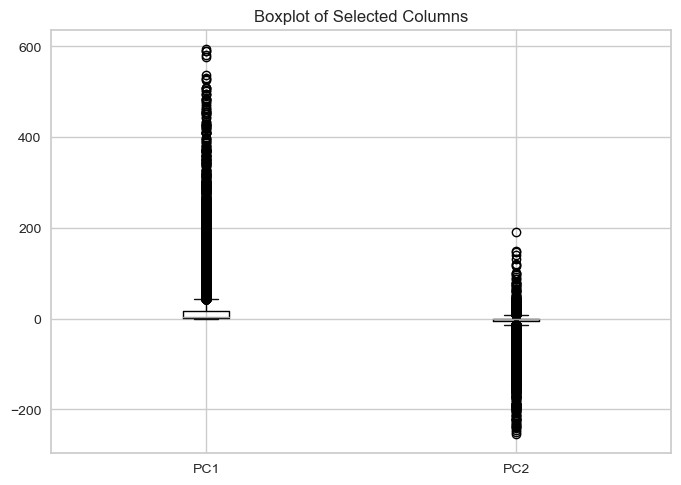

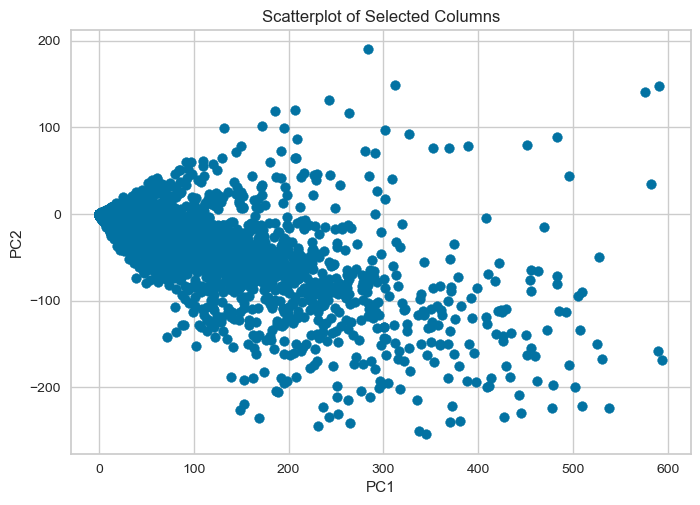

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class DataEDAPCA:
    def __init__(self, columns, z_threshold=10):
        self.columns = columns
        self.z_threshold = z_threshold
        self.removed_indices = None

    def plot_box_and_scatter(self, X):
        # Create a boxplot of the specified columns
        X[self.columns].boxplot()
        plt.title("Boxplot of Selected Columns")
        plt.show()

        # Create a scatterplot of the specified columns
        plt.scatter(X[self.columns[0]], X[self.columns[1]])
        plt.xlabel(self.columns[0])
        plt.ylabel(self.columns[1])
        plt.title("Scatterplot of Selected Columns")
        plt.show()

    def remove_outliers(self, X):
        # Calculate Z-scores for the specified columns
        z_scores = np.abs(stats.zscore(X[self.columns]))
        z_scores = z_scores.to_numpy()  # Convert to a NumPy array
        print("Z-scores:")
        print(z_scores)
        print("Z-threshold:", self.z_threshold)

        # Find the indices of rows with Z-scores exceeding the threshold
        outlier_indices = np.argwhere(z_scores > self.z_threshold)
        outlier_indices = outlier_indices.ravel()
        print("Outlier Indices:", outlier_indices)

        # Drop the rows with high Z-scores
        X.drop(X.index[outlier_indices], inplace=True)
        self.removed_indices = outlier_indices

    def fit_transform(self, X, another_df=None):
        # Step 1: Display initial boxplot and scatterplot
        self.plot_box_and_scatter(X)

        # Step 2: Notify rows with high Z-scores and remove them
        self.remove_outliers(X)

        # Step 3: If another_df is provided, subset it using the same indices
        removed_metadata = None
        if another_df is not None:
            removed_metadata = another_df.iloc[self.removed_indices]

        # Step 4: Display boxplot and scatterplot of the updated data
        self.plot_box_and_scatter(X)

        return X, removed_metadata

# Example usage:
eda_pca = DataEDAPCA(columns=["PC1", "PC2"])
updated_train_pca_df, removed_metadata = eda_pca.fit_transform(train_pca_df, metadata)


In [101]:
updated_train_pca_df

,PC1,PC2
PKD_CAGCAATAGTCGGCCT-1_3,0.138904,-0.014086
PKD_GGATCTACAACCCTCT-1_2,0.203921,-0.140785
PKD_AGCGCCAAGCCGTTGC-1_3,0.511251,-0.104547
PKD_GGGTGTCAGTCCCGGT-1_2,0.521988,-0.184444
PKD_CCATAAGCAGAGTTCT-1_1,30.737445,-8.892647
...,...,...
PKD_ATCCTATGTTCCTAGA-1_3,39.704073,-17.631396
PKD_GGCTGTGAGGAACGAA-1_1,29.823898,-15.172695
PKD_AGGCCACCACAACCGC-1_1,83.125263,-6.222025
PKD_GGAATGGAGCCAAGGT-1_2,18.421691,-10.114620


In [96]:
removed_metadata

,name,barcode,patient,gender,disease,celltype,nCount_RNA,nFeature_RNA,UMAP_1,UMAP_2
905,PKD_AGGGCCTGTTGTCCCT-1_1,AGGGCCTGTTGTCCCT-1,PKD1,female,PKD,PT1,1543.645651,1513,5.360233,-6.968874
1,PKD_ACACGCGGTTTGGCTA-1_1,ACACGCGGTTTGGCTA-1,PKD1,female,PKD,PT2,1865.542588,1650,2.499409,-6.587287
1187,PKD_ATACCTTGTGTTTACG-1_1,ATACCTTGTGTTTACG-1,PKD1,female,PKD,TAL1,1322.570418,1280,-8.709750,-4.845766
1,PKD_ACACGCGGTTTGGCTA-1_1,ACACGCGGTTTGGCTA-1,PKD1,female,PKD,PT2,1865.542588,1650,2.499409,-6.587287
1943,PKD_CAATCGACAGAGAGGG-1_1,CAATCGACAGAGAGGG-1,PKD1,female,PKD,TAL1,1263.223684,1317,-7.660759,-4.829868
...,...,...,...,...,...,...,...,...,...,...
1,PKD_ACACGCGGTTTGGCTA-1_1,ACACGCGGTTTGGCTA-1,PKD1,female,PKD,PT2,1865.542588,1650,2.499409,-6.587287
22071,PKD_CAAGAGGAGCAGGCTA-1_3,CAAGAGGAGCAGGCTA-1,PKD3,female,PKD,LEUK,813.314504,1073,7.410253,7.429642
1,PKD_ACACGCGGTTTGGCTA-1_1,ACACGCGGTTTGGCTA-1,PKD1,female,PKD,PT2,1865.542588,1650,2.499409,-6.587287
22363,PKD_CAGCACGAGCAAGTCG-1_3,CAGCACGAGCAAGTCG-1,PKD3,female,PKD,DCT,2037.680784,1734,-8.619582,5.442869


In [99]:
updated_train_pca_df.shape, train_pca_df.shape

((22335, 2), (22335, 2))

In [86]:
columns=["PC1", "PC2"]

In [87]:
z_scores = np.abs(stats.zscore(train_pca_df[train_pca_df.columns]))

In [92]:
print(z_scores)

                               PC1       PC2
PKD_CATCGCTCACTCAGAT-1_3  0.079476  0.225277
PKD_GGACGTCGTATGGGAC-1_2  0.087175  0.212520
PKD_AGTACTGCAATGCAGG-1_3  0.083620  0.200164
PKD_CTGCCATTCTTCGTAT-1_2  0.849577  4.677955
PKD_CAGCAATAGTCGGCCT-1_3  0.090506  0.227379
...                            ...       ...
PKD_ATCCTATGTTCCTAGA-1_3  0.047664  0.239786
PKD_GGCTGTGAGGAACGAA-1_1  0.013160  0.174588
PKD_AGGCCACCACAACCGC-1_1  0.199299  0.062761
PKD_GGAATGGAGCCAAGGT-1_2  0.026659  0.040461
PKD_CGTTGGGGTGTTAACC-1_3  0.090830  0.226525

[22376 rows x 2 columns]


In [90]:
outlier_indices = np.argwhere(z_scores > abs(10))

ValueError: Shape of passed values is (2, 41), indices imply (22376, 2)

In [ ]:
train_pca_df.columns

In [ ]:
eda_pca = DataEDAPCA(columns=["PC1", "PC2"])
updated_train_pca_df, removed_metadata = eda_pca.fit_transform(train_pca_df, metadata)

In [ ]:
train_pca_df

In [ ]:
eda_pca = DataEDAPCA(columns=["PC1", "PC2"])

# Fit and transform the dataset
pca_train_df_filtered = eda_pca.fit_transform(train_pca_df, metadata)

# Access removed values
removed_values = eda_pca.removed_values

# Access the updated PCA dataset
updated_pca_train_df = pca_train_df_filter

## Clustering on the Train Data

In [ ]:
def optimize_and_compare_kmeans(data, kmeans_params, alpha=0.05):
    # Perform Grid Search
    grid = GridSearchCV(KMeans(), kmeans_params, cv=3, refit=True)
    grid.fit(data)
    grid_search_estimator = grid.best_estimator_

    # Calculate silhouette scores
    default_kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(data)
    default_silhouette_score = silhouette_score(data, default_kmeans.labels_)
    grid_search_silhouette_score = silhouette_score(data, grid_search_estimator.labels_)

    # Perform a two-sample t-test only if Grid Search performs better
    if grid_search_silhouette_score > default_silhouette_score:
        t_stat, p_value = stats.ttest_ind(default_kmeans.labels_, grid_search_estimator.labels_)

        # Set the default choice to "Grid Search Estimator"
        choice = "KMeans Estimator"

        # Output informative print statements
        print("Default KMeans Silhouette Score:", default_silhouette_score)
        print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)

        if p_value < alpha:
            choice = "Grid Search Estimator"
            print("The difference between the two groups is statistically significant.")
            print(f"Using {choice} as it performs significantly better using a threshold of alpha = .05 .")
            return choice, grid_search_estimator
        else:
            print("The difference between the two groups is not statistically significant.")
            print(f"Using {choice} as there is no significant improvement using a threshold of alpha = .05.")
            return choice, default_kmeans
    else:
        choice = "Default Parameter"
        print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)
        print("Default KMeans Silhouette Score:", default_silhouette_score)
        print("Default Parameter has a higher Silhouette Score.")
        print("Using Default Parameter as it performs better based on Silhouette Score.")
        return choice, default_kmeans

     # Return both choice and the chosen KMeans clusterer


# Usage example with parameters
kmeans_params = {
    'n_clusters': list(range(1, 10)),
    'init': ['random', 'k-means++'],
    'n_init': [1, 5, 10],
    'max_iter': [300],
    'random_state': [0]
}
choice, k_means_estimator = optimize_and_compare_kmeans(train_without_outliers, kmeans_params)

In [ ]:
k_means_estimator

In [ ]:
def find_outliers_in_clusters(data, clusterer, n_neighbors=20, contamination=0.1):
    # Fit the Local Outlier Factor (LOF) model on the data
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    outliers = lof.fit_predict(data)

    # Create a DataFrame to store cluster labels and outlier labels
    cluster_outliers = pd.DataFrame({'Cluster': clusterer.labels_, 'Outlier': outliers})

    # Print the number of data points and percentage of outliers in each cluster
    cluster_info = cluster_outliers.groupby('Cluster').agg(DataPoints=('Cluster', 'count'),
                                                          PercentageOutliers=('Outlier', lambda x: (x == -1).mean() * 100))
    print("Cluster Information:")
    print(cluster_info)

    return cluster_outliers

# Example usage:
# Assuming you already have a KMeans clusterer 'chosen_kmeans' from the previous code
outliers_in_clusters = find_outliers_in_clusters(train_without_outliers, k_means_estimator)
outliers_in_clusters



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(8, 6))

# Create a scatter plot to visualize the clustering
sns.scatterplot(x='PC1', y='PC2', data=train_without_outliers, hue=k_means_estimator.labels_, palette='viridis', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Visualization')

# Show the plot
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [ ]:
from sklearn.cluster import HDBSCAN

In [ ]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) == 1:
        return 0  # Silhouette score is undefined for a single cluster
    return silhouette_score(X, labels)

def optimize_and_compare_hdbscan(data, hdbscan_params, alpha=0.05):
    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=HDBSCAN(min_cluster_size=20),
        param_grid=hdbscan_params,
        scoring=silhouette_scorer,
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(data)
    grid_search_estimator = grid_search.best_estimator_

    # Calculate silhouette scores for the default and grid search estimators
    default_hdbscan = HDBSCAN(min_cluster_size=20).fit(data)
    default_labels = default_hdbscan.labels_
    default_silhouette_score = silhouette_score(data, default_labels)

    grid_search_labels = grid_search_estimator.fit_predict(data)
    grid_search_silhouette_score = silhouette_score(data, grid_search_labels)

    # Check if the grid search estimator has a higher silhouette score
    if grid_search_silhouette_score > default_silhouette_score:
        # Perform a two-sample t-test
        t_stat, p_value = stats.ttest_ind(default_labels, grid_search_labels)

        # Check if the p-value is less than the significance level
        if p_value < alpha:
            choice = "Grid Search Estimator"
        else:
            choice = "Default Parameter"
    else:
        choice = "Default Parameter"

    # Output informative print statements
    print("Default HDBSCAN Silhouette Score:", default_silhouette_score)
    print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)

    if grid_search_silhouette_score > default_silhouette_score:
        if p_value < alpha:
            print("The difference between the two groups is statistically significant.")
            print(f"Using {choice} as it performs significantly better.")
        else:
            print("The difference between the two groups is not statistically significant.")
            print(f"Using {choice} as there is no significant improvement.")
    else:
        print("Default Parameter has a higher silhouette score. No t-test performed.")

    return choice

# Define the parameter grid for HDBSCAN
hdbscan_params = {
    'min_samples': [10, 30, 50, 60, 100],
    'min_cluster_size': [100, 200, 300, 400, 500, 600],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['euclidean', 'manhattan']
}

# Usage example with parameters
result = optimize_and_compare_hdbscan(train_without_outliers, hdbscan_params)

In [ ]:
result

https://towardsdatascience.com/tuning-with-hdbscan-149865ac2970

Things to consider


1) Get the clustering to work in a pipeline
2) Are these ok default parameters
3) What to do with the test data
4) Should we be using silhoute on grid search or should i be optimizaing it differently
5) Are we normalizing it the right way? Since normalize is working along rows is this dealing with out of domain sampels? Just used standard scalar because no normalizers could work and some of them did along rows
6) Make it so it put things in folders
7) Quality check NAS? How do to this with a sparse matrix
8) Do soemthing like she did in notebook 3 to label the data set
9) Naive classifier and base? 
10) Would k-means be base what is naive?
